In [1]:
import sys, os
sys.path.insert(0, os.path.abspath(".."))

# Join coords to street segments

We make use of the fact that some of the dataset contains both longitude/latitude coordinates and projected `xy` coordinates.
- The lon/lat coords appear to be "correct", and to fall very close to the centre of the street, outside the actual building the event occurred in.

The complete procedure is this:

- Look at each point where we have both a lon/lat coordinate, and an `xy` coordinate.
- Find the "segment" of the street network graph which the lon/lat coordinate falls in
- Partition space into Voroni cells from the `xy` coordinate
- Our map then takes the interior of the Voroni cell to the segment of the graph.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.collections
import numpy as np
import os, lzma, hashlib
import open_cp.geometry
open_cp.geometry.configure_gdal()
import pyproj
proj = pyproj.Proj({"init":"EPSG:2845"})
import descartes
import tilemapbase

import opencrimedata.tiger_lines
import opencrimedata.dallas
import opencrimedata.voroni
import opencrimedata.replace

## Load street network and crime event data

Only look at crime events where we have _both_ `xy` and `lonlat` coordinates.

In [3]:
datadir = os.path.join("..", "..", "..", "..", "Data")
#datadir = os.path.join("/media", "disk", "Data")
tigerdir = os.path.join(datadir, "TIGER Data")
#tigerdir = os.path.join("/media", "disk", "TIGER Data")

In [4]:
#filename = os.path.join(datadir, "Dallas_11_Sept_2017.csv.xz")
filename = os.path.join(datadir, "Dallas_7_Dec_2017.csv.xz")
with lzma.open(filename, "rt") as file:
    data = [row for row in opencrimedata.dallas.load_full(file)
            if row.lonlat is not None and row.xy is not None]
len(data), data[0]

(120223,
 Row(code='276285-2016', crime_type='BURGLARY', crime_subtype='BURGLARY-RESIDENCE', start_time=datetime.datetime(2016, 11, 16, 11, 0), end_time=datetime.datetime(2016, 11, 18, 11, 0), call_time=datetime.datetime(2016, 11, 18, 11, 42, 26), address='5850 BELT LINE RD', city='DALLAS 75254', lonlat=(-96.807131, 32.953948), xy=(758206.7262484236, 2144003.9338816064)))

In [5]:
#streets = opencrimedata.tiger_lines.TigerLines(
#    os.path.join(tigerdir, "tl_2016_48113_roads__dallas_county"),
#    os.path.join(tigerdir, "tl_2016_48113_edges__dallas_county"),
#    proj)
#graph, edge_list = streets.make_reduced_graph()

streets = list(row
    for row in opencrimedata.dallas.load_street_lines(os.path.join(datadir, "Dallas Streets Shapefile - Polyline"))
    if opencrimedata.dallas.street_clazz_accept(row))

def street_proj(row):
    l = np.asarray(row.line)
    return np.asarray(proj(*l.T)).T

graph, edge_list = opencrimedata.geometry.graph_from_streets(streets, street_proj)

In [6]:
segments = list(open_cp.network.segment_graph(graph))

edge_id_to_containing_segment = {}
for seg in segments:
    for eid in seg:
        edge_id_to_containing_segment[eid] = seg

## Plots

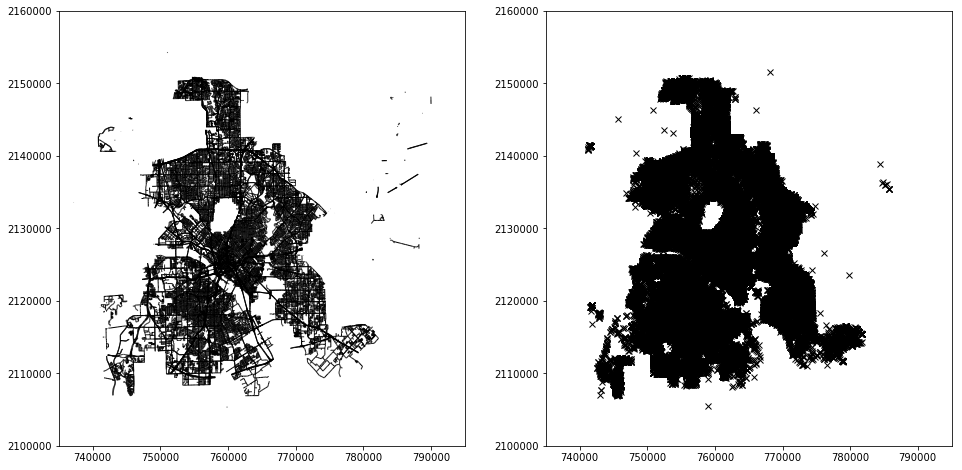

In [7]:
fig, axes = plt.subplots(ncols=2, figsize=(16,8))

ax = axes[0]
li = matplotlib.collections.LineCollection(graph.as_lines(), color="black", linewidth=1)
ax.add_collection(li)

pts = np.asarray([proj(*row.lonlat) for row in data])
ax = axes[1]
ax.scatter(*pts.T, color="black", marker="x", linewidth=1)

x, y = 765000, 2130000
d = 30*1000
for ax in axes:
    ax.set(xlim=[x-d, x+d], ylim=[y-d,y+d])

## Project points to the street network

From observation, the `lonlat` points are pretty much on the stree network anyway, so just project to make sure.

In [8]:
def project_to_segment(lon, lat):
    x, y = proj(lon, lat)
    edge, t = graph.project_point_to_graph(x, y)
    edge_id, _ = graph.find_edge(*edge)
    return edge_id_to_containing_segment[edge_id]

In [9]:
row = data[32]
row

Row(code='277059-2016', crime_type='THEFT', crime_subtype='OTHER THEFTS', start_time=datetime.datetime(2016, 11, 18, 1, 0), end_time=datetime.datetime(2016, 11, 18, 5, 0), call_time=datetime.datetime(2016, 11, 19, 14, 13, 39), address='6008 RIDGECREST RD', city='DALLAS 75231', lonlat=(-96.759039, 32.87015), xy=(762899.4179145248, 2134783.279896747))

In [10]:
for eid in project_to_segment(*row.lonlat):
    #idx = edge_list[eid]
    #print(streets.merged_names[idx])
    for r in edge_list[eid]:
        print(r.name, r.left, r.right)

RIDGECREST RD StreetAddress(start=6301, end=6329) StreetAddress(start=6300, end=6328)
RIDGECREST RD StreetAddress(start=6301, end=6329) StreetAddress(start=6300, end=6328)
RIDGECREST RD StreetAddress(start=6001, end=6099) StreetAddress(start=6000, end=6098)
RIDGECREST RD StreetAddress(start=6001, end=6099) StreetAddress(start=6000, end=6098)
RIDGECREST RD StreetAddress(start=6301, end=6329) StreetAddress(start=6300, end=6328)
RIDGECREST RD StreetAddress(start=6331, end=6399) StreetAddress(start=6330, end=6398)
RIDGECREST RD StreetAddress(start=6401, end=6499) StreetAddress(start=6400, end=6498)
RIDGECREST RD StreetAddress(start=6501, end=6599) StreetAddress(start=6500, end=6598)
RIDGECREST RD StreetAddress(start=6501, end=6599) StreetAddress(start=6500, end=6598)
RIDGECREST RD StreetAddress(start=6201, end=6299) StreetAddress(start=6200, end=6298)
RIDGECREST RD StreetAddress(start=6201, end=6299) StreetAddress(start=6200, end=6298)
RIDGECREST RD StreetAddress(start=6101, end=6199) Stre

### How much do we move the points?

In [16]:
distances = []
for row in data:
    if row.lonlat is None:
        continue
    x, y = proj(*row.lonlat)
    edge, t = graph.project_point_to_graph(x, y)
    xx, yy = graph.edge_to_coords(*edge, t)
    distances.append((xx-x)**2 + (yy-y)**2)
distances = np.sqrt(distances)

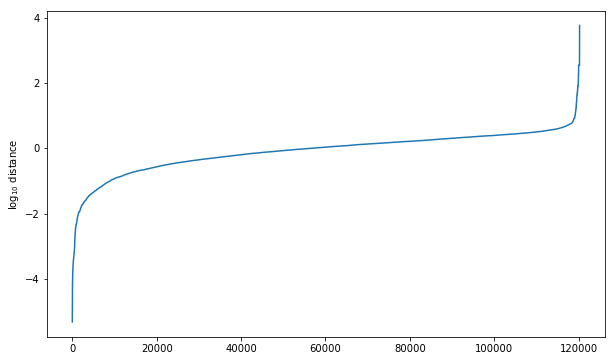

In [22]:
dist_sorted = np.sort(distances)
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(np.log10(dist_sorted))
ax.set(ylabel="$\log_{10}$ distance")
None

In [26]:
dist_sorted[int(len(dist_sorted)*0.99)]

8.3515594561706958

## Lookup from Voroni cells to segments

- Want to ignore cases which we think are "errors": large gaps between the 2 coordinates
- Set the bar at 250m, which excludes about 2% of cases

In [26]:
data_to_use = []
for row in data:
    x, y = proj(*row.lonlat)
    xx, yy = row.xy
    distance = np.sqrt((x-xx)**2 + (y-yy)**2)
    if distance <= 250:
        data_to_use.append(row)
        
len(data_to_use) / len(data)

0.9784567012967569

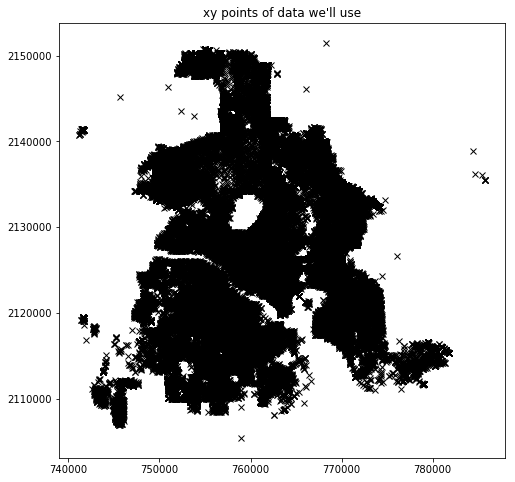

In [27]:
fig, ax = plt.subplots(figsize=(8,8))

pts = np.asarray([row.xy for row in data_to_use])
ax.scatter(*pts.T, marker="x", color="black", linewidth=1)
ax.set_title("xy points of data we'll use")
None

Add some extra points on a large circle around the data, to stop annoying "edge effects".

In [28]:
centre = np.mean(pts, axis=0)
radius = np.sqrt(np.max(np.sum((pts - centre)**2,axis=1))) + 500

data_to_use_points_to_row = {row.xy : row for row in data_to_use}

voroni_points = [row.xy for row in data_to_use]
num_pts = 100
for i in range(num_pts):
    angle = 2 * np.pi * i / num_pts
    x = np.cos(angle) * radius + centre[0]
    y = np.sin(angle) * radius + centre[1]
    voroni_points.append((x,y))
    
voroni_points = np.asarray(voroni_points)

In [29]:
voroni = opencrimedata.voroni.Voroni(voroni_points)
redist = voroni.to_redistributor(None)

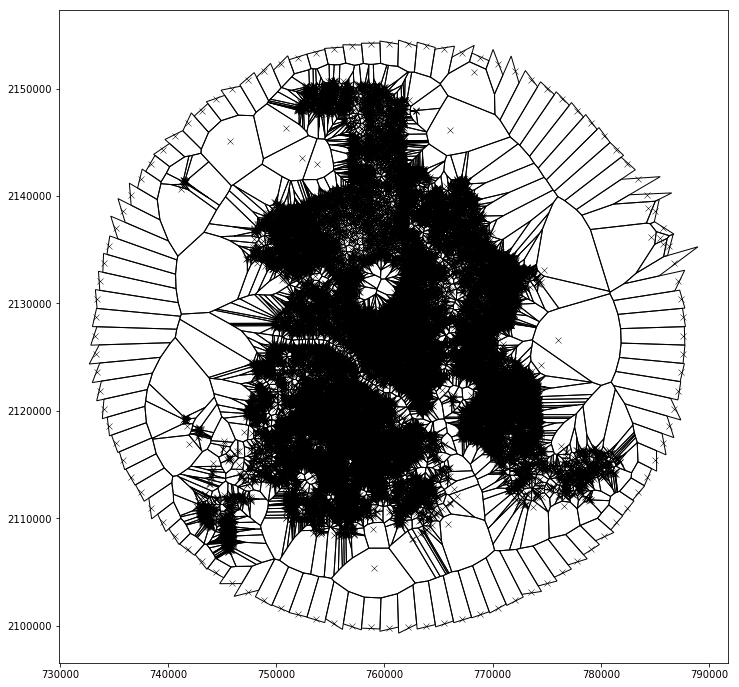

In [30]:
fig, ax = plt.subplots(figsize=(12,12))

for p in redist.polygons:
    patch = descartes.PolygonPatch(p, fc="none", ec="black", linewidth=1)
    ax.add_patch(patch)
    
ax.scatter(*voroni.merged_points.T, marker="x", linewidth=0.5, color="black")
None

In [31]:
class MappedOutsideGeometryError(Exception):
    pass

def segment_from_location(x, y):
    pindex = redist.find_containing_polygon(x, y)
    if len(pindex) == 0:
        raise MappedOutsideGeometryError()
    assert len(pindex) == 1
    pindex = pindex[0]
    pt = voroni.merged_points[pindex]
    try:
        row = data_to_use_points_to_row[tuple(pt)]
    except KeyError:
        raise MappedOutsideGeometryError()
    return project_to_segment(*row.lonlat)

In [32]:
row = data[6421]
print(row)
seg = segment_from_location(*row.xy)
print(seg)
for eid in seg:
    #idx = edge_list[eid]
    #print(streets.merged_names[idx])
    for r in edge_list[eid]:
        print(r.name, r.left, r.right)

Row(code='290423-2015', crime_type='THEFT', crime_subtype='OTHER THEFTS', start_time=datetime.datetime(2015, 12, 14, 10, 0), end_time=datetime.datetime(2015, 12, 14, 10, 30), call_time=datetime.datetime(2015, 12, 14, 13, 20, 5), address='1211 E LOUISIANA AVE', city='DALLAS 75216', lonlat=(-96.807102, 32.723836), xy=(758638.800666102, 2118529.5130466972))
{271492, 271493, 271494, 271495, 271496, 271497, 271498}
E LOUISIANA AVE StreetAddress(start=1201, end=1299) StreetAddress(start=1200, end=1298)
E LOUISIANA AVE StreetAddress(start=1201, end=1299) StreetAddress(start=1200, end=1298)
E LOUISIANA AVE StreetAddress(start=1201, end=1299) StreetAddress(start=1200, end=1298)
E LOUISIANA AVE StreetAddress(start=1201, end=1299) StreetAddress(start=1200, end=1298)
E LOUISIANA AVE StreetAddress(start=1201, end=1299) StreetAddress(start=1200, end=1298)
E LOUISIANA AVE StreetAddress(start=1201, end=1299) StreetAddress(start=1200, end=1298)
E LOUISIANA AVE StreetAddress(start=1201, end=1299) Street

# Redistribution

Map to segment, and then choose location uniformly at random in the segment.

In [33]:
def choice_along_segment(seg):
    lengths = [graph.length(eid) for eid in seg]
    total_length = sum(lengths)
    t = np.random.random() * total_length
    for eid, length in zip(seg, lengths):
        v1, v2 = graph.edges[eid]
        if t <= length:
            return graph.edge_to_coords(v1, v2, t / length)
        t -= length
    raise AssertionError()

In [34]:
class Assign(opencrimedata.replace.AssignNew):
    def adjust(self, row):
        if row.xy is None:
            return None
        try:
            seg = segment_from_location(*row.xy)
        except MappedOutsideGeometryError:
            print("Skipping", row)
            return None
        x, y = choice_along_segment(seg)
        return opencrimedata.dallas.row_with_new_position(row, x, y)

In [35]:
def input_gen():
    with lzma.open(filename, "rt") as file:
        yield from opencrimedata.dallas.load_full(file)

assign = Assign(input_gen(), seed=1234)

with lzma.open(os.path.join(datadir, "Dallas_Redist_1.csv.xz"), "wt", newline="") as f:
    opencrimedata.dallas.write(f, assign)

Skipping Row(code='018638-2015', crime_type='MOTOR VEHICLE ACCIDENT', crime_subtype='ACCIDENT MV', start_time=datetime.datetime(2015, 1, 24, 16, 30), end_time=datetime.datetime(2015, 1, 24, 16, 32), call_time=datetime.datetime(2015, 1, 24, 16, 31, 33), address='10001 DALROCK RD', city='DALLAS 75089', lonlat=None, xy=(784528.663392189, 2143572.021388758))
Skipping Row(code='028490-2015', crime_type='CRIMINAL MISCHIEF/VANDALISM', crime_subtype='CRIMINAL MISCHIEF/VANDALI', start_time=datetime.datetime(2015, 2, 5, 22, 30), end_time=datetime.datetime(2015, 2, 5, 22, 31), call_time=datetime.datetime(2015, 2, 5, 21, 50, 16), address='3200 TIMBERLINE DR', city='PLANO 75074', lonlat=None, xy=(771442.9300966909, 2151736.5266680964))
Skipping Row(code='030019-2015', crime_type='CRIMINAL MISCHIEF/VANDALISM', crime_subtype='VANDALISM & CRIM MISCHIEF', start_time=datetime.datetime(2015, 2, 7, 20, 40), end_time=datetime.datetime(2015, 2, 7, 20, 41), call_time=datetime.datetime(2015, 2, 7, 20, 5, 38),

- in: `618ef2890c9c9c6ed1a8641221b5107386e8f26dd2a58e065c00e38f66f02954`
- out: linux: `f6cf8594f0f0285543eacffbb34bfaa221b20db518ab08ad06c9c26046cf53b0`
  - win: `7f173d90ef0cb4adc897a01acb7fa36728aaa20d5eab1d41dd463ad72889ebf0`
- Failed to assign: 8177
- Input size: 301526

In [36]:
assign.input_hash

'618ef2890c9c9c6ed1a8641221b5107386e8f26dd2a58e065c00e38f66f02954'

In [37]:
assign.output_hash

'1467a6a7d01bd61eb12e29f3a9c3ce898ed565add0397b73eadb8007062df966'

In [38]:
assign.failed_to_reassign_count, assign.input_size

(8177, 301526)

# Reload and check

In [27]:
print(filename)
with lzma.open(filename, "rt") as f:
    old_data = list(opencrimedata.dallas.load_full(f))

..\..\..\..\Data\Dallas_7_Dec_2017.csv.xz


In [28]:
with lzma.open(os.path.join(datadir, "Dallas_Redist_1.csv.xz"), "rt") as f:
    new_data = list(opencrimedata.dallas.load(f))

In [29]:
# Check we haven't doubled up...
assert len(set(row.code for row in old_data)) == len(old_data)
assert len(set(row.code for row in new_data)) == len(new_data)

In [30]:
old_data = {row.code : row for row in old_data}
new_data = {row.code : row for row in new_data}

In [31]:
for x, new_row in new_data.items():
    row = old_data[x]
    assert tuple(row)[:-2] == tuple(new_row)[:-2]
    assert new_row.lonlat is None

In [32]:
in_old_only = {x for x in old_data if x not in new_data}
print("In old only:", len(in_old_only))
print("Without xy coords:", sum(old_data[x].xy is None for x in in_old_only))

In old only: 8177
Without xy coords: 8125


## Distance moved

For those rows with old lon/lat coords, how much do we move?

In [41]:
distances, graph_distances = [], []
for code, row in old_data.items():
    if code in new_data and row.lonlat is not None:
        x, y = proj(*row.lonlat)
        xx, yy = new_data[code].xy
        distances.append((xx-x)**2 + (yy-y)**2)
        edge, t = graph.project_point_to_graph(x, y)
        xx, yy = graph.edge_to_coords(*edge, t)
        graph_distances.append((xx-x)**2 + (yy-y)**2)
distances = np.sqrt(distances)
graph_distances = np.sqrt(graph_distances)

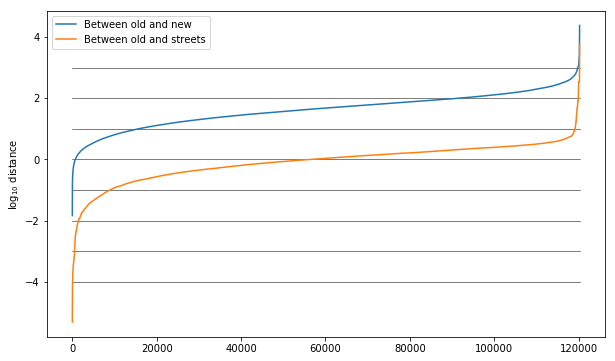

In [44]:
fig, ax = plt.subplots(figsize=(10,6))
for x in range(-4,4):
    ax.plot([0, len(distances)], [x, x], linewidth=0.5, color="black")
dist_sorted = np.sort(distances)
ax.plot(np.log10(dist_sorted), label="Between old and new")
dist_sorted = np.sort(graph_distances)
ax.plot(np.log10(dist_sorted), label="Between old and streets")
ax.set(ylabel="$\log_{10}$ distance")
ax.legend()
None

# Plots

In [ ]:
new_pts_wm, old_pts_wm = [], []
for key in new_data:
    if old_data[key].lonlat is None:
        continue
    new_pts_wm.append(tilemapbase.project(*proj(*new_data[key].xy, inverse=True)))
    old_pts_wm.append(tilemapbase.project(*old_data[key].lonlat))
new_pts_wm = np.asarray(new_pts_wm)
old_pts_wm = np.asarray(old_pts_wm)

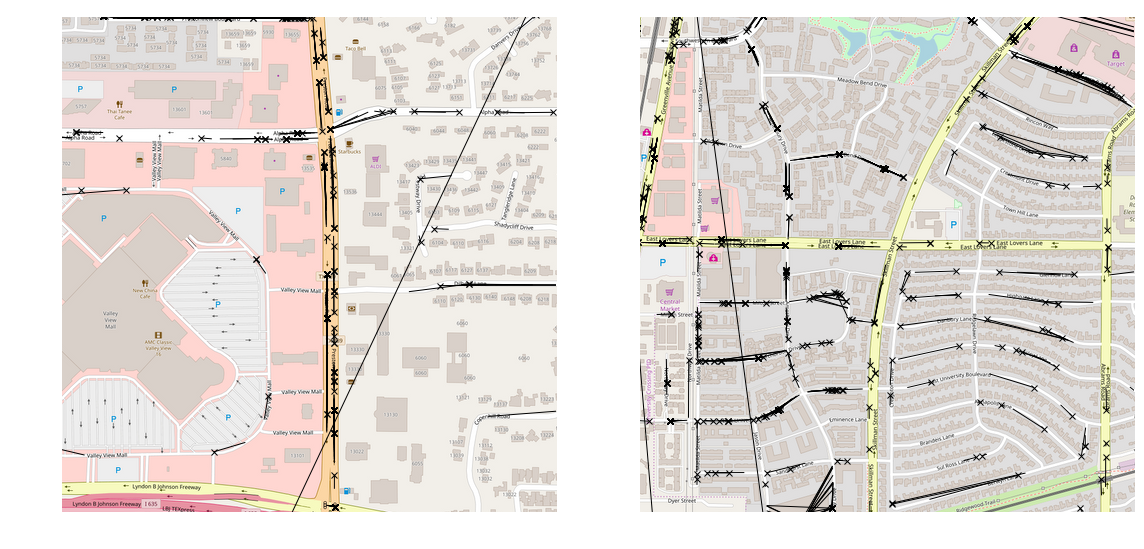

In [47]:
fig, axes = plt.subplots(ncols=2, figsize=(16,8))

ex = tilemapbase.Extent.from_centre(0.2311, 0.40303, xsize=0.00003)
plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=800)
plotter.plot(axes[0])

ex = tilemapbase.Extent.from_centre(0.23122, 0.403295, xsize=0.00005)
plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=800)
plotter.plot(axes[1])

for ax in axes:
    ax.scatter(*old_pts_wm.T, marker="x", color="black", linewidth=1)
    #ax.scatter(*new_pts_wm.T, marker="o", color="black", linewidth=1)
    lines = list(zip(new_pts_wm, old_pts_wm))
    l = matplotlib.collections.LineCollection(lines, color="black", linewidth=1)
    ax.add_collection(l)
    ax.set_axis_off()
fig.tight_layout()

In [48]:
fig.savefig("dallas_coords_to_streets.png", dpi=150)

# Save to shapefile

From browsing around QGIS, the result is surprising accurate.  It gets it wrong by a block, occasionally...

In [48]:
import geopandas as gpd
import shapely.geometry

In [49]:
frame = gpd.GeoDataFrame({
    "crime" : [row.crime_type for row in new_data.values()],
    "address" : [row.address for row in new_data.values()]
    })
frame.geometry = [shapely.geometry.Point(*row.xy) for row in new_data.values()]
frame.crs = {"init":"EPSG:2845"}
frame.head()

,address,crime,geometry
0,5850 BELT LINE RD,BURGLARY,POINT (758190.6762580645 2144023.898810261)
1,4400 W DAVIS ST,MOTOR VEHICLE ACCIDENT,POINT (750638.5412506985 2121242.403304039)
2,600 E COLORADO BLVD,FOUND PROPERTY,POINT (757870.440064008 2122370.742565405)
3,400 CRESCENT CT,THEFT,POINT (758881.8908244856 2126312.726526797)
4,11901 AUDELIA RD,FOUND PROPERTY,POINT (766651.897560579 2139374.220335281)


In [34]:
#frame.to_file("dallas_redist")